In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

c:\Users\gemin\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\gemin\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\gemin\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os
path = os.environ.get("DATASET_PATH")
if path is None:
    path = "./data"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 1024
image_size = 12

In [4]:
## Ready for dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((image_size, image_size))])


class MNISTDataset(Dataset):
    def __init__(self, transform):
        super().__init__()
        dataset = MNIST(path, download=True, transform=transform)
        # self.data = [data.flatten() for data, _ in dataset]
        self.data = [data for data, _ in dataset]
    
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)



dataset = MNISTDataset(transform)
# load the dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

c:\Users\gemin\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


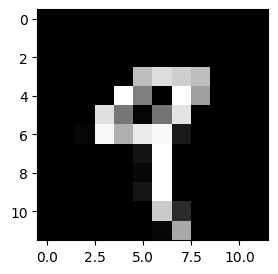

In [5]:
# load the dataset
idx = 4
img = dataset[idx].numpy().reshape(image_size, image_size)
plt.figure(figsize=(3,3))
plt.imshow(img, cmap="gray")

## Forward process

In [6]:
def plot_process(xs):
    N = len(xs)
    # show the result of forward process
    plt.figure(figsize=((N)*2, 3),)
    for i in range(N):
        ax = plt.subplot(1, N, 1+i)
        ax.set_axis_off()
        ax.imshow(xs[i].numpy(), cmap='gray')

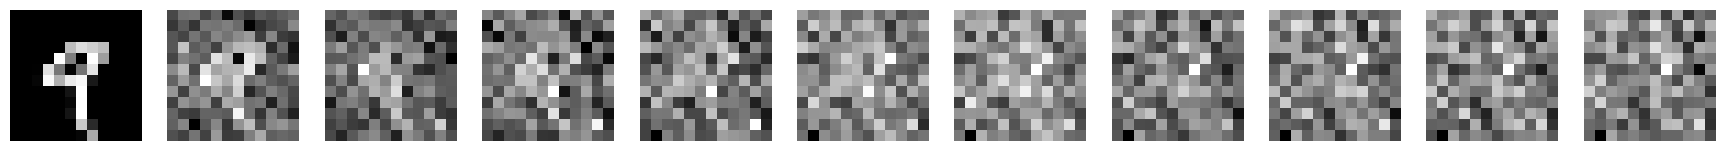

In [7]:
def forward_process(x0, T, betas):
    datas = [x0]
    x = x0
    for t in range(T):
        # Gaussian diffusion 
        x = x* torch.sqrt(1 - betas[t]) + torch.sqrt(betas[t]) * torch.randn_like(x) # x * mu + std * eps
        datas.append(x)
    return datas

# num of steps
T = 10
betas = torch.tensor([0.08]*T)
x0 = torch.Tensor(img)
xs = forward_process(x0, T, betas)

# plot the images
plot_process(xs)

## Directly compute the foward diffusion process $q(x_t|x_0)$

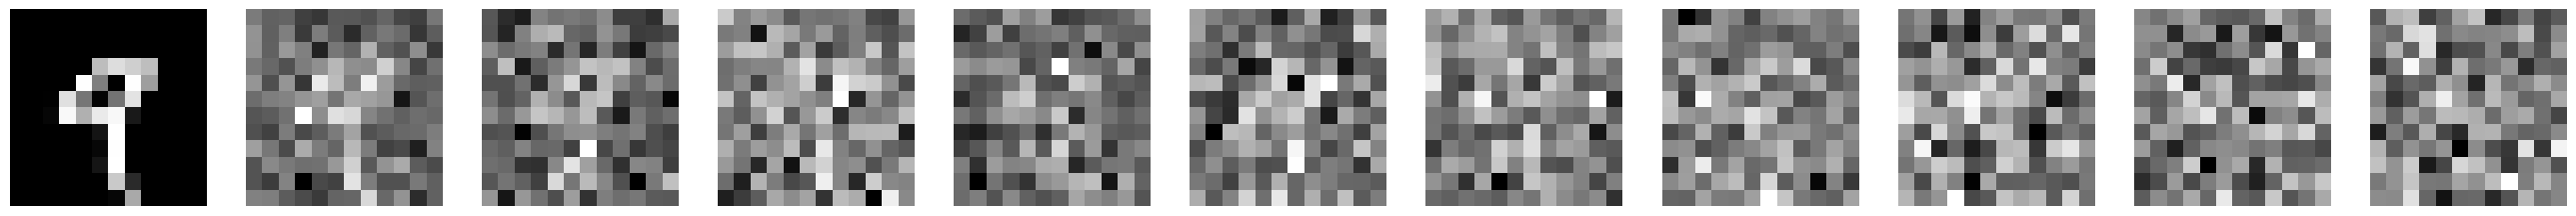

In [8]:
def foward_process_at(x0, alphas_bar, t:int):
    if t == 0: return x0
    t -= 1
    # diffusion step t
    return x0*torch.sqrt(alphas_bar[t]) + torch.sqrt(1 - alphas_bar[t]) * torch.randn_like(x0)

alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0)

# show the result of forward process
plt.figure(figsize=((T+1)*3, 3))
for i in range(T+1):
    ax = plt.subplot(1, T+1, 1+i)
    ax.set_axis_off()
    ax.imshow(foward_process_at(x0, alphas_bar, i).numpy(), cmap='gray')

## Varations of betas

In [9]:
import math
def create_betas(steps:int, start, end, type="linear"):
    betas = None
    if type == "linear":
        betas = torch.linspace(start, end, steps)
    elif type == "power":
        betas = torch.linspace(math.sqrt(start), math.sqrt(end), steps)**2
    elif type == "sigmoid":
        betas = torch.sigmoid(torch.linspace(-10, 8, steps))*(end-start) + start
    return betas

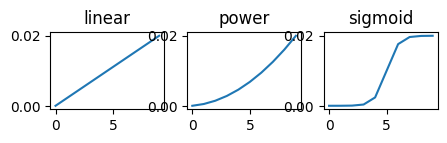

In [10]:
betas = (create_betas(10, 1e-4, 0.02, 'linear'), 'linear'), (create_betas(10, 1e-4, 0.02, 'power'), 'power'), (create_betas(10, 1e-4, 0.02, 'sigmoid'), 'sigmoid')

def plot_betas(betas):
    fig, axs = plt.subplots(1, len(betas), figsize=(5, 1))
    for i in range(len(betas)):
        axs[i].plot(betas[i][0])
        axs[i].set_title(betas[i][1])
        # axs[i].set_axis_off()
    plt.show()

plot_betas(betas)


## Model Implementations

In Algorithm 1, gradient descent step
$$\nabla_{\theta} ||\epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_{t}}\epsilon, t)||^2$$

In Algorithm 2,
$$$$

In [11]:
from typing import Tuple

class DiffusionModel(nn.Module):
    """
    Algorithms in Denoising Diffusion Probabilistic Model Paper
    """
    def __init__(self, T:int, model, device='cpu'):
        super().__init__()
        self.T = T
        # used linear
        self.betas = create_betas(self.T, 1e-4, 0.02, 'linear').to(device)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        
        self.model = model.to(device)

    def inference(self, sample_size:int, n_channels:int, img_size:Tuple[int,int], device='cpu'):
        """From algorithm 2 from paper"""
        xt = torch.randn([sample_size, n_channels, *img_size]).to(device)
        
        for t in range(self.T-1, -1, -1):
            z = torch.randn_like(xt).to(device) if t > 0 else torch.zeros_like(xt).to(device)
            t = torch.full((sample_size,), t, dtype=torch.long, device=device)
            # needs alpha, alphabar and beta(sigma) of t
            beta_t = self.betas[t].reshape(-1, 1, 1, 1)
            alpha_t = self.alphas[t].reshape(-1, 1, 1, 1)
            alpha_bar_t = self.alphas_bar[t].reshape(-1, 1, 1, 1)
            xt = (1 / torch.sqrt(alpha_t) * (xt - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * self.model(xt, t))) + torch.sqrt(beta_t) * z
        return xt

        
    def forward(self, x0):
        """compute the loss : one step of gradient descent. algorithm 1 from paper"""
        batch_size = x0.shape[0]
        
        # randomly select the `t`
        t = torch.randint(0, self.T, (batch_size,)).to(x0.device)

        eps = torch.randn_like(x0)
        
        # x0 [B, C, W, H]
        # alpha_bar_t also need to be 4 dim.
        alpha_bar_t = self.alphas_bar[t].reshape(-1, 1, 1, 1)
        eps_theta = self.model(torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t)
        loss = F.mse_loss(eps, eps_theta)
        return loss


In [12]:
def plot_imgs(imgs, img_size, size, scores=None, save_file=None):
    imgs = imgs.view(-1, img_size, img_size)
    f, axarr = plt.subplots(size[0], size[1], figsize=(4, 4))
    for i in range(size[1]):
        for j in range(size[0]):
            idx = i*size[0]+j
            axarr[i, j].imshow(imgs[idx,:].numpy(), cmap='gray')
            axarr[i, j].set_axis_off()

            # only for discriminator
            if scores is not None:
                axarr[i,j].text(0.0, 0.5, str(round(scores[idx], 2)), dict(size=20, color='red'))

    if save_file is not None:
        plt.savefig(save_file)
    plt.show()

In [13]:
hidden_dim = 256
steps = 40
epochs = 2_500

learning_rate = 1e-4

In [14]:
## Train
from tqdm.notebook import tqdm

def train(model:nn.Module, optimizer, epochs, device='cpu'):
    model = model.to(device).train()

    training_loss = []
    for epoch in tqdm(range(epochs)):
        
        batch_loss = 0.0
        for batch_data in dataloader:
            batch_data = batch_data.to(device)

            loss = model(batch_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1} - loss : {batch_loss}')
            # data = model.inference(9, device).cpu().detach()
            data = model.inference(9, 1, (image_size, image_size), device).cpu().detach()
            plot_imgs(data, image_size, (3,3))
            

        training_loss.append(batch_loss)
    return training_loss

In [15]:
class SimpleUNet(nn.Module):
    def __init__(self, T, in_channels, out_channels, emb_dim=32, hidden_channels=64):
        super().__init__()

        self.T = T
        self.emb_dim = emb_dim
        self.emb = nn.Embedding(T, emb_dim)
        self.linear1 = nn.Linear(emb_dim, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, hidden_channels*2)



        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(in_channels, hidden_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = conv_block(hidden_channels, hidden_channels*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.middle1 = conv_block(hidden_channels*2, hidden_channels*2)
        self.middle2 = conv_block(hidden_channels*2, hidden_channels*2)
                                    

        self.up_conv1 = up_conv(hidden_channels*2, hidden_channels*2)
        self.decoder1 = conv_block(hidden_channels*4, hidden_channels*2)
        self.up_conv2 = up_conv(hidden_channels*2, hidden_channels)
        self.decoder2 = conv_block(hidden_channels*2, hidden_channels)

        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)


    def forward(self, x, t):
        if not torch.is_tensor(t):
            t = torch.tensor([t]).to(x.device).long()
        batch_size = x.shape[0]
        emb = self.emb(t)
        emb = self.linear1(emb)
        emb2 = self.linear2(emb)
        emb2 = emb2.reshape(batch_size, -1, 1, 1)
        emb = emb.reshape(batch_size, -1, 1, 1)

        # down
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1*emb)
        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2*emb2)

        middle = self.middle1(pool2*emb2)
        middle = self.middle1(middle*emb2)

        # up
        up1 = self.up_conv1(middle)
        concat1 = torch.cat([up1, enc2], dim=1)
        dec1 = self.decoder1(concat1)
        up2 = self.up_conv2(dec1*emb2)
        concat2 = torch.cat([up2, enc1], dim=1)
        dec2 = self.decoder2(concat2)

        out = self.out_conv(dec2)
        return out

In [16]:
net = SimpleUNet(steps, 1, 1)
model = DiffusionModel(steps, net,device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 100 - loss : 7.750699259340763


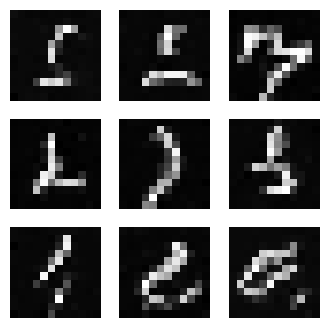

Epoch 200 - loss : 7.04761803150177


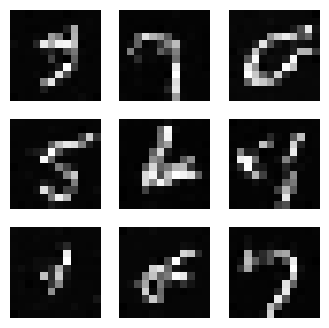

Epoch 300 - loss : 6.744114086031914


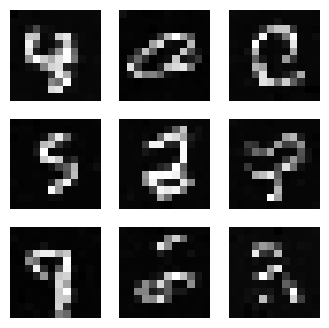

Epoch 400 - loss : 6.535152919590473


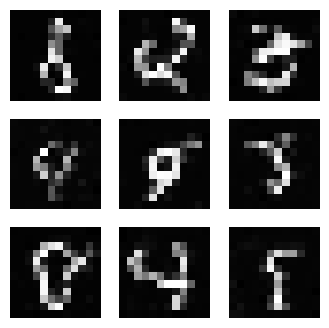

Epoch 500 - loss : 6.389751717448235


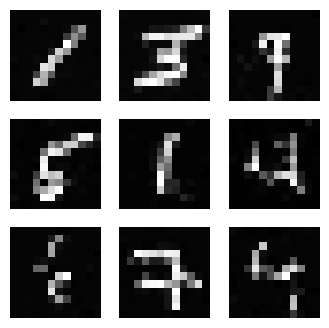

Epoch 600 - loss : 6.265176340937614


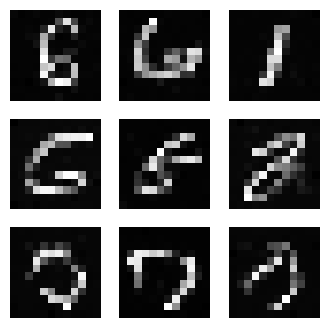

Epoch 700 - loss : 6.17296838760376


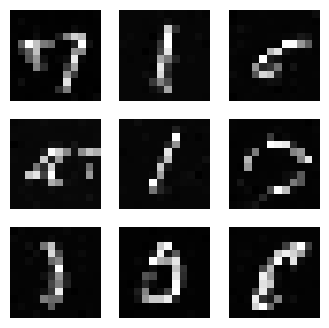

Epoch 800 - loss : 6.113168776035309


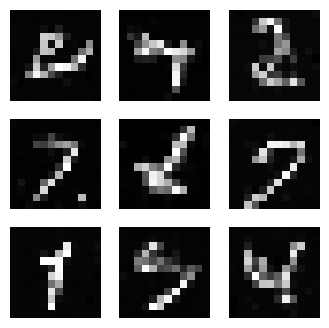

Epoch 900 - loss : 6.037948630750179


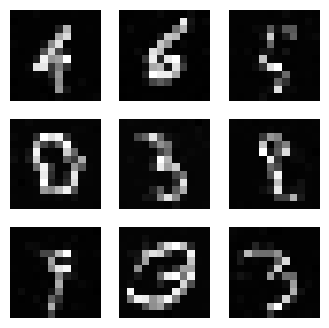

Epoch 1000 - loss : 5.989183388650417


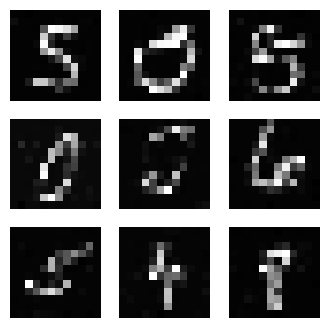

Epoch 1100 - loss : 5.954465448856354


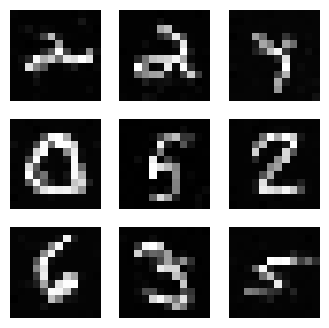

Epoch 1200 - loss : 5.904856026172638


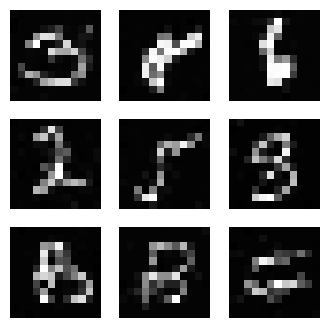

Epoch 1300 - loss : 5.883901424705982


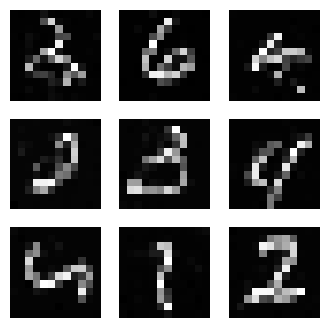

Epoch 1400 - loss : 5.839655637741089


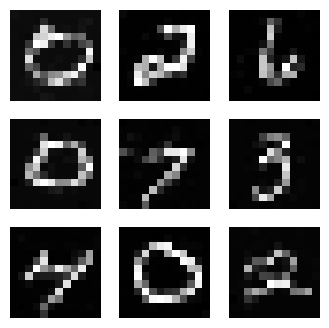

Epoch 1500 - loss : 5.8460833132267


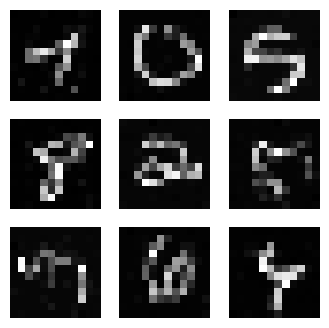

Epoch 1600 - loss : 5.819785460829735


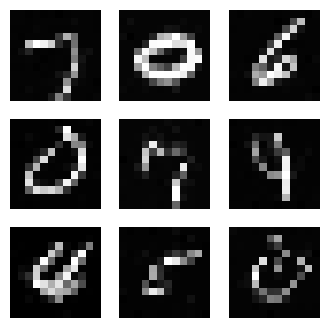

Epoch 1700 - loss : 5.804199881851673


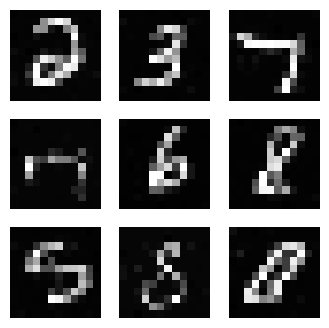

Epoch 1800 - loss : 5.786968812346458


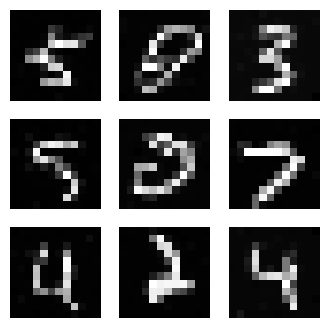

Epoch 1900 - loss : 5.733175419270992


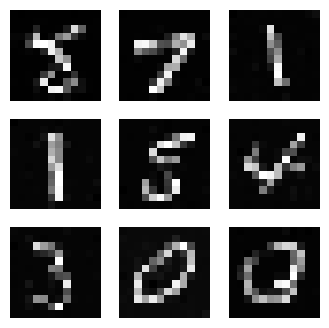

Epoch 2000 - loss : 5.739284589886665


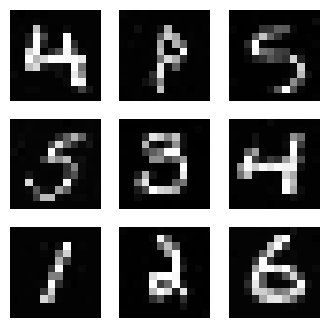

Epoch 2100 - loss : 5.714490942656994


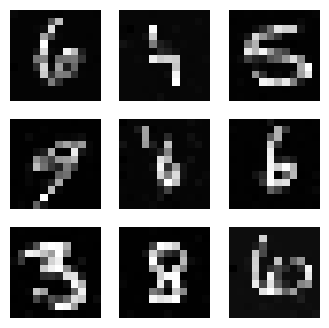

Epoch 2200 - loss : 5.692693188786507


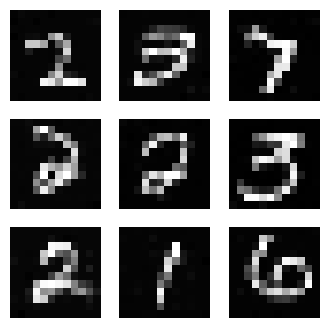

Epoch 2300 - loss : 5.683777391910553


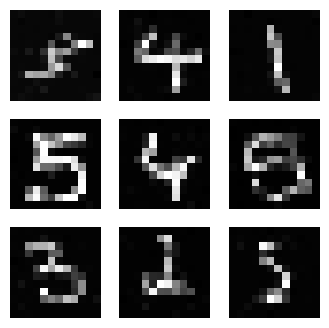

Epoch 2400 - loss : 5.709635011851788


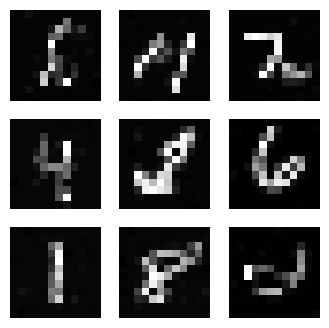

Epoch 2500 - loss : 5.690706893801689


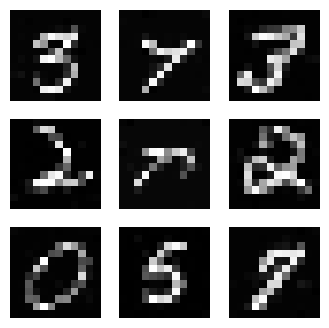

In [17]:
losses = train(model, optimizer=optimizer, epochs=epochs, device=device)